Create a multi-layer perceptron neural network model to predict on a labeled dataset of your choosing. Compare this model to either a boosted tree or a random forest model and describe the relative tradeoffs between complexity and accuracy. Be sure to vary the hyperparameters of your MLP!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

import mdst


In [2]:
df = pd.read_csv('vgsales.csv')

In [3]:
mdst.null_summary(df)

total rows:  16598


,null_counts,pct_nulls,dtype
Rank,0,0,int64
Name,0,0,object
Platform,0,0,object
Year,271,1.6327,float64
Genre,0,0,object
Publisher,58,0.3494,object
NA_Sales,0,0,float64
EU_Sales,0,0,float64
JP_Sales,0,0,float64
Other_Sales,0,0,float64


In [4]:
df.dropna(inplace=True)

In [5]:
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [6]:
# beginnings of my own convenience functions for feature engineering and data exploration
class Features_df():
    def __init__(self, df, y_col, test_size=.25, random_state=33):
        self.df = df.copy()
        self.df.index = range(len(df))
        self.numeric_col_names = list(df.select_dtypes(exclude=[object]).columns)
        self.numeric_col_names.remove(y_col)
        self.categorical_col_names = list(df.select_dtypes(include=[object]).columns)
        self.added_col_names = []
        self.original_col_names = list(df.columns)
        self.y_col = y_col
        self.capped_outlier_col_names = []
        self.pca_dct = {}
        
        
        self.test_size = test_size
        self.random_state = random_state

        self.train_df = self.df.sample(frac=1-self.test_size ,random_state=self.random_state)
        self.test_df = self.df.drop(self.train_df.index)
        

    def box_cox_y(self):
        self.df['bc'+self.y_col], self.bc_y_lambda = boxcox(self.df[self.y_col])
              
    def train_test_df_update(self):
        ''' re-initializes self.train_df and self.test_df based on current self.df
        Feature engineer on self.df and call update to incorporate changes on training and testing df
        '''
        self.train_df = self.df.sample(frac=1-self.test_size ,random_state=self.random_state)
        self.test_df = self.df.drop(self.train_df.index)
        
        
    def get_dummies(self, cols=None):
        
        if not cols:
            cols=self.categorical_col_names

        self.most_common_dummy_dct = {}

        for col_name in cols:
            most_common = col_name + '_' + self.df[col_name].value_counts().index[0]
            self.most_common_dummy_dct[col_name] = most_common
              
        dummies_df = pd.get_dummies(self.df[cols], prefix=cols)
        self.df = pd.concat([self.df, dummies_df], axis=1)
        
        self.dummy_dct = {col: [d_col for d_col in dummies_df.columns if col in d_col] for col in cols}
            
    def drop_most_common_dummy(self, cols=None):
        
        if not cols:
            cols=self.most_common_dummy_dct.keys()
                
        cols_to_drop = [self.most_common_dummy_dct[i] for i in cols]
        self.df = self.df.drop(cols_to_drop, axis=1)

    def get_poly_features(self, cols=None, degree=2):
        
        if not cols:
            cols = self.numeric_col_names
        
        poly = PolynomialFeatures(degree)
        poly_df = pd.DataFrame(poly.fit_transform(self.df[cols]))
        self.poly_col_names = poly.get_feature_names()

        for i, col in reversed(list(enumerate(self.df[cols]))):
            self.poly_col_names = [pcn.replace('x'+str(i),col) for pcn in self.poly_col_names]

        poly_df.columns = self.poly_col_names
        
        poly_df.index = self.df.index
        
#         self.poly_df = self.poly_df.drop(self.numeric_col_names, axis=1)
        self.df = pd.concat([self.df, poly_df.drop(cols, axis=1)], axis=1)
        self.poly_col_names = [col for col in self.poly_col_names if col not in cols]
    
    def standardize_cols(self, cols=None):
        if not cols:
            cols = self.numeric_col_names
        scaler = StandardScaler()
        self.st_cols = []
        for col in cols:
            new_col = col+'_scaled'
            self.df[new_col] = scaler.fit_transform(self.df[[col]]).reshape(-1,)
            self.st_cols.append(new_col)
    
    def box_all_standard(self, cols=None):
        if not cols:
            try:
                cols = self.st_cols
            except:
                self.standardize_cols()
                cols = self.st_cols

        plt.figure(figsize=(20, len(cols)))
        sns.boxplot(data=self.df[cols], orient='h')

        
    def pca(self, name='all', cols=None):
        self.train_test_df_update()
        
        if not cols:
            cols = [col for col in self.df.columns if col not in self.categorical_col_names]

        pca = PCA()
        # fit on training data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(self.train_df[cols])
        pca.fit(scaled_data)
        
        # transform on entire dataset
        pca_array = pca.transform(self.df[cols])
        
        pca_col_names = [name+'_pca_'+str(i+1) for i in range(len(cols))]
        pca_df = pd.DataFrame(pca_array, columns=pca_col_names)
        self.df = pd.concat([self.df, pca_df], axis=1)
        self.pca_dct[name] = pca
        
        self.train_test_df_update()
    
    def display_feature_categories(self):
        self.added_col_names = list(self.df.columns) - self.original_col_names - self.poly_col_names - self.dummy_col_names
        print('numeric_col_names: {}'.format(self.numeric_col_names,))
        print('categorical_col_names: {}'.format(self.cagtegorical_col_names))
        print('poly_col_names: {}'.format(self.poly_col_names))
        print('added_col_names: {}'.format(self.added_col_names))
        print('original_col_names: {}'.format(self.original_col_names))
        
    def group_by_original_cols(self):
        self.origin_col_dct = {original_col:[] for original_col in self.original_col_names}
        for col in self.df.columns:
            for original_col in self.original_col_names:
                if original_col in col:
                    self.origin_col_dct[original_col] += [col]
                    
            
    def outlier_report(self, cols=None):
        if not cols:
            cols = [self.y_col] + self.numeric_col_names
            
        odf = pd.DataFrame(cols, columns=['column'])
        
        def outlier_cutoffs(arr):
            q1, q3 = arr.quantile(0.25), arr.quantile(0.75)
            iqr = q3-q1
            lower_co, upper_co = q1 - 1.5*(q3-q1), q3 + 1.5*(q3-q1)
            return (lower_co, upper_co)

        
        odf['lower_co'] = odf['column'].apply(lambda x: outlier_cutoffs(self.df[x])[0])
        odf['upper_co'] = odf['column'].apply(lambda x: outlier_cutoffs(self.df[x])[1])
        
        odf['upper_outlier_count'] = odf[['column','upper_co']].apply(
                                                lambda x: len(self.df[(self.df[x[0]] > x[1])]), axis=1)
        odf['lower_outlier_count'] = odf[['column','lower_co']].apply(
                                                lambda x: len(self.df[(self.df[x[0]] < x[1])]), axis=1)
        
        odf['total_outlier_count'] = odf['upper_outlier_count'] + odf['lower_outlier_count']
        
        odf = odf[odf.columns[::-1]]
        
        outliers_col_df = odf.set_index('column')
        
        self.outliers_col_df = outliers_col_df
        
        
        
        
#         ordf = self.df.copy()[cols]
        
        ordf = pd.DataFrame()
        ordf['outlier_sum'] = 0
        for col in cols:
            a = self.df[col]
            lower_co = outliers_col_df.loc[col,'lower_co']
            upper_co = outliers_col_df.loc[col,'upper_co']
            ordf[col] = a.mask((a>lower_co)&(a<upper_co))
        ordf['outlier_sum'] = ordf.count(axis=1)
        
        self.outliers_row_df = ordf.sort_values(by='outlier_sum',ascending=False)
        
    def cap_outliers(self, cols=None):
        if not cols:
            cols = self.numeric_col_names

        for col in cols:
            lower_co = self.outliers_col_df.loc[col, 'lower_co']
            upper_co = self.outliers_col_df.loc[col, 'upper_co']
            
            a = self.df[col]
            self.df[col+' capped_outliers'] = a.where(a > lower_co, lower_co)
            
            b = self.df[col+' capped_outliers']
            self.df[col+' capped_outliers'] = b.where(b < upper_co, upper_co)

            self.capped_outlier_col_names.append(col+' capped_outliers')
            
    def rounded_bins(self, cols=None, bins=5):
        if not cols:
            cols = self.numeric_col_names
            
        for col in cols:
            bin_size = (self.df[col].max() - self.df[col].min())/bins
            labels = [self.df[col].min()+b*bin_size+.5*bin_size for b in range(bins)]

            self.df[col+' rounded_bins'] = pd.to_numeric(pd.cut(self.df[col], bins, labels=labels))
        self.rounded_bins_cols = [col+' rounded_bins' for col in cols]

In [7]:
features = Features_df(df, 'NA_Sales')

In [8]:
features.get_dummies(cols=['Publisher', 'Platform', 'Genre'])

In [9]:
features.train_test_df_update()

# OOB

In [10]:
cols = ['Year', 'EU_Sales', 'JP_Sales']

# Platform dummies
cols += [
 'Platform_2600',
 'Platform_3DO',
 'Platform_3DS',
 'Platform_DC',
 'Platform_DS',
 'Platform_GB',
 'Platform_GBA',
 'Platform_GC',
 'Platform_GEN',
 'Platform_GG',
 'Platform_N64',
 'Platform_NES',
 'Platform_NG',
 'Platform_PC',
 'Platform_PCFX',
 'Platform_PS',
 'Platform_PS2',
 'Platform_PS3',
 'Platform_PS4',
 'Platform_PSP',
 'Platform_PSV',
 'Platform_SAT',
 'Platform_SCD',
 'Platform_SNES',
 'Platform_TG16',
 'Platform_WS',
 'Platform_Wii',
 'Platform_WiiU',
 'Platform_X360',
 'Platform_XB',
 'Platform_XOne']

# Genere Dummies
cols += [
 'Genre_Action',
 'Genre_Adventure',
 'Genre_Fighting',
 'Genre_Misc',
 'Genre_Platform',
 'Genre_Puzzle',
 'Genre_Racing',
 'Genre_Role-Playing',
 'Genre_Shooter',
 'Genre_Simulation',
 'Genre_Sports',
 'Genre_Strategy']

In [11]:
# split, fit, and score
X_train, y_train = features.train_df[cols], features.train_df['NA_Sales']
X_test, y_test = features.test_df[cols], features.test_df['NA_Sales']
X, y = features.df[cols], features.df['NA_Sales']


mlp = MLPRegressor()

mlp.fit(X_train,y_train)
print('training score: ',mlp.score(X_train, y_train))
print('testing score: ', mlp.score(X_test, y_test))


training score:  0.44007704883846843
testing score:  0.5704419588894087


c:\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


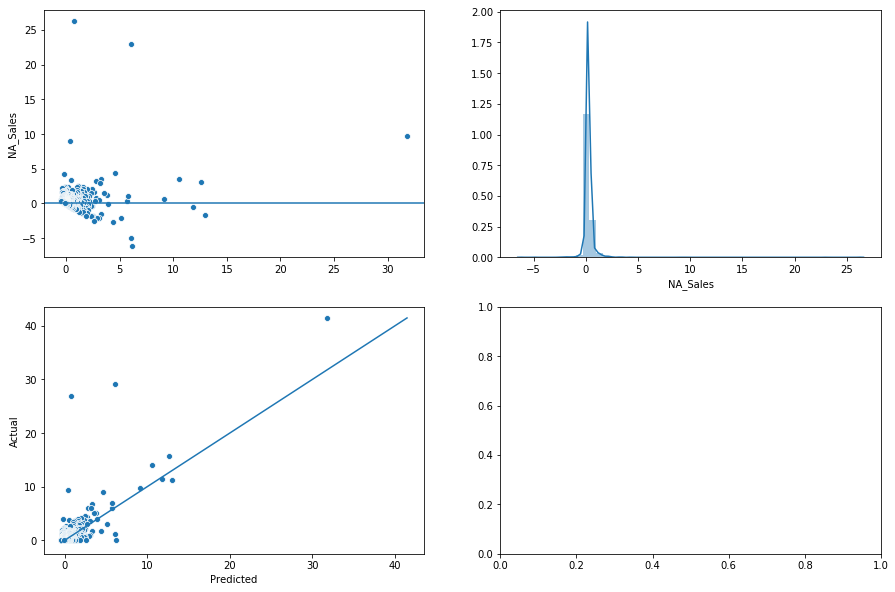

In [12]:
actual = features.test_df['NA_Sales']
predicted = mlp.predict(features.test_df[cols])

mdst.diagnostic_graphs_LR(actual, predicted)

In [13]:
# split, fit, and score
# X_train, y_train = features.train_df[cols], features.train_df['NA_Sales']
# X_test, y_test = features.test_df[cols], features.test_df['NA_Sales']
# X, y = features.df[cols], features.df['NA_Sales']


rf = RandomForestRegressor()

rf.fit(X_train,y_train)
print('training score: ',rf.score(X_train, y_train))
print('testing score: ', rf.score(X_test, y_test))


c:\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


training score:  0.9353139276202397
testing score:  0.5251172608476182


c:\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


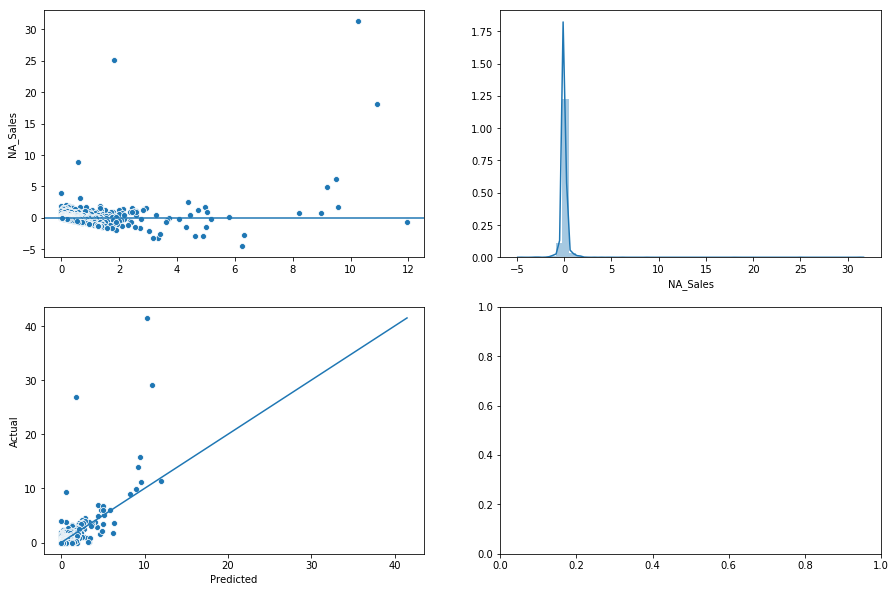

In [14]:
actual = features.test_df['NA_Sales']
predicted = rf.predict(features.test_df[cols])

mdst.diagnostic_graphs_LR(actual, predicted)

# Tuned

In [15]:
cols = ['Year', 'EU_Sales', 'JP_Sales']

# Platform dummies
cols += [
 'Platform_2600',
 'Platform_3DO',
 'Platform_3DS',
 'Platform_DC',
 'Platform_DS',
 'Platform_GB',
 'Platform_GBA',
 'Platform_GC',
 'Platform_GEN',
 'Platform_GG',
 'Platform_N64',
 'Platform_NES',
 'Platform_NG',
 'Platform_PC',
 'Platform_PCFX',
 'Platform_PS',
 'Platform_PS2',
 'Platform_PS3',
 'Platform_PS4',
 'Platform_PSP',
 'Platform_PSV',
 'Platform_SAT',
 'Platform_SCD',
 'Platform_SNES',
 'Platform_TG16',
 'Platform_WS',
 'Platform_Wii',
 'Platform_WiiU',
 'Platform_X360',
 'Platform_XB',
 'Platform_XOne']

# Genere Dummies
cols += [
 'Genre_Action',
 'Genre_Adventure',
 'Genre_Fighting',
 'Genre_Misc',
 'Genre_Platform',
 'Genre_Puzzle',
 'Genre_Racing',
 'Genre_Role-Playing',
 'Genre_Shooter',
 'Genre_Simulation',
 'Genre_Sports',
 'Genre_Strategy']

In [16]:
# split, fit, and score
X_train, y_train = features.train_df[cols], features.train_df['NA_Sales']
X_test, y_test = features.test_df[cols], features.test_df['NA_Sales']
X, y = features.df[cols], features.df['NA_Sales']


mlp = MLPRegressor((15,), solver='adam', activation='relu')

mlp.fit(X_train,y_train)
print('training score: ',mlp.score(X_train, y_train))
print('testing score: ', mlp.score(X_test, y_test))


training score:  0.5980689233951324
testing score:  0.6349302116931397


In [17]:
cv = cross_val_score(mlp, X_train, y_train, cv=5)
print('cross val score: ', cv.mean(), cv.std())
cv

cross val score:  0.6073837073056849 0.09159612035098999


array([0.65962014, 0.68603191, 0.5993912 , 0.43319913, 0.65867615])

c:\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


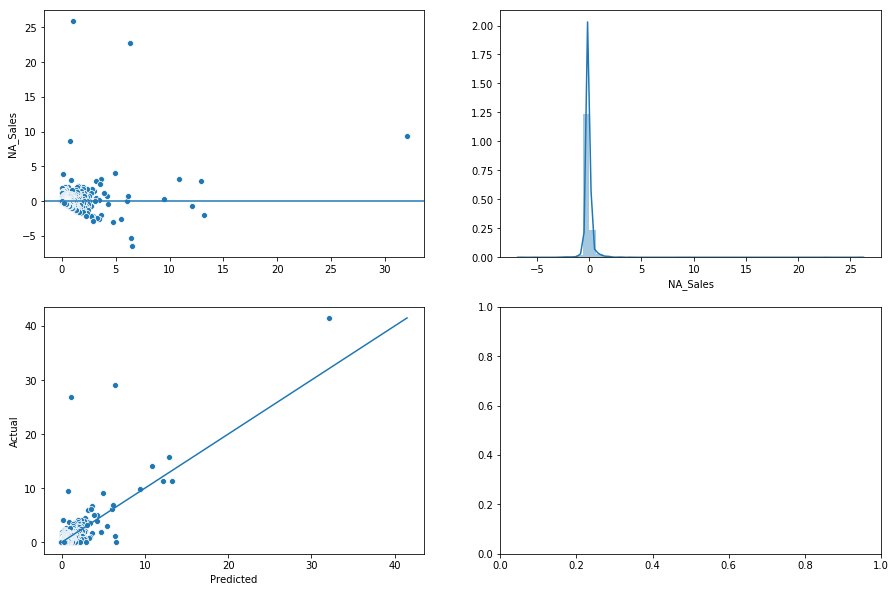

In [18]:
actual = features.test_df['NA_Sales']
predicted = mlp.predict(features.test_df[cols])

mdst.diagnostic_graphs_LR(actual, predicted)

In [19]:
# split, fit, and score
# X_train, y_train = features.train_df[cols], features.train_df['NA_Sales']
# X_test, y_test = features.test_df[cols], features.test_df['NA_Sales']
# X, y = features.df[cols], features.df['NA_Sales']


rf = RandomForestRegressor(n_estimators = 100, max_depth=20, min_samples_leaf=2, min_samples_split=5, max_features=.5)

rf.fit(X_train,y_train)
print('training score: ',rf.score(X_train, y_train))
print('testing score: ', rf.score(X_test, y_test))


training score:  0.8820797353328773
testing score:  0.5365861639294214


In [20]:

cv = cross_val_score(rf, X_train, y_train, cv=5)
print('cross val score: ', cv.mean(), cv.std())
cv

cross val score:  0.7082729404314125 0.08817081371768676


array([0.80758103, 0.78956308, 0.68443798, 0.56080871, 0.6989739 ])

c:\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


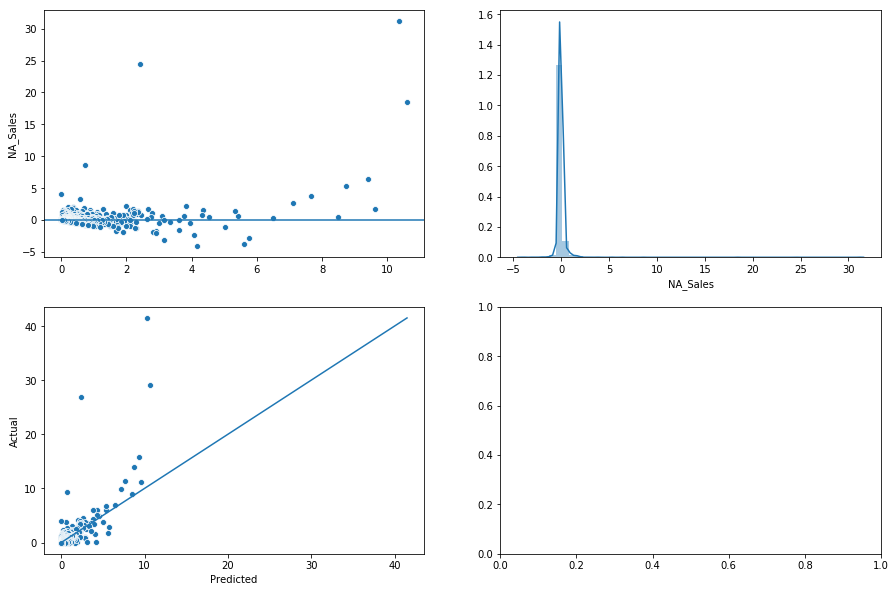

In [21]:
actual = features.test_df['NA_Sales']
predicted = rf.predict(features.test_df[cols])

mdst.diagnostic_graphs_LR(actual, predicted)